Source:
[stock-prediction-pytorch](https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch)

In [13]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np

In [39]:
stock_list = ['AMZN']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [40]:
data = AMZN
data.reset_index(inplace=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-05-16,961.000000,970.059998,960.909973,966.070007,966.070007,3126100
1,2017-05-17,954.700012,960.400024,944.119995,944.760010,944.760010,5145600
2,2017-05-18,944.799988,962.750000,944.760010,958.489990,958.489990,3939300
3,2017-05-19,962.840027,968.919983,959.719971,959.840027,959.840027,3972100
4,2017-05-22,964.000000,971.380005,962.900024,970.669983,970.669983,2642200


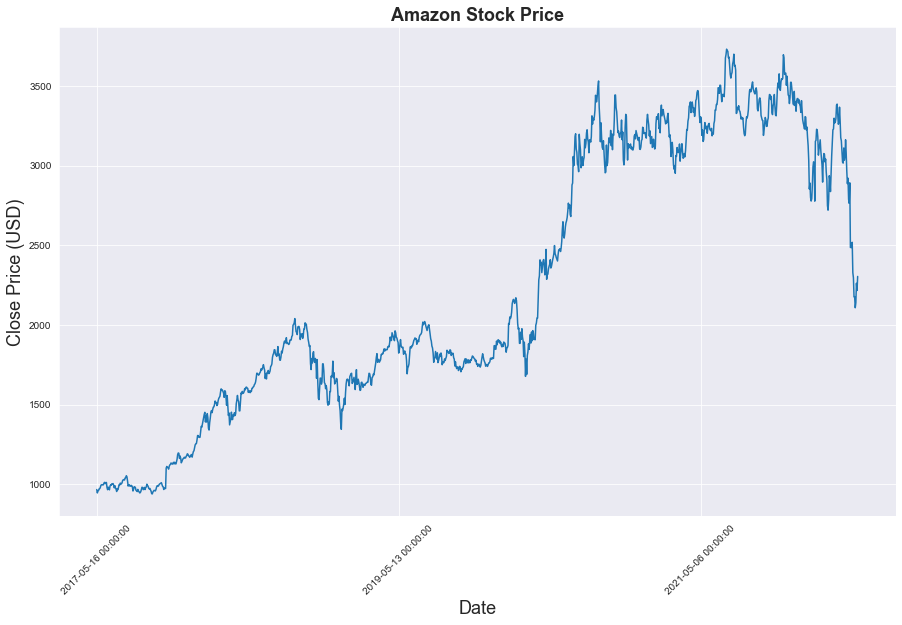

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [42]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1261 non-null   float64
dtypes: float64(1)
memory usage: 10.0 KB


In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/sh/ghxrfz3946z44kkqlbdt4l8j61y3q1/T/ipykernel_94633/68737012.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [46]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (993, 19, 1)
y_train.shape =  (993, 1)
x_test.shape =  (248, 19, 1)
y_test.shape =  (248, 1)


In [47]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
y_train_transformer = torch.from_numpy(y_train).type(torch.Tensor)
y_test_transformer = torch.from_numpy(y_test).type(torch.Tensor)

In [48]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [18]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [19]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.3525358736515045
Epoch  1 MSE:  0.27010348439216614
Epoch  2 MSE:  0.2209390103816986
Epoch  3 MSE:  0.22816741466522217
Epoch  4 MSE:  0.16742190718650818
Epoch  5 MSE:  0.12221228331327438
Epoch  6 MSE:  0.08169304579496384
Epoch  7 MSE:  0.047794174402952194
Epoch  8 MSE:  0.04179603233933449
Epoch  9 MSE:  0.05044250562787056
Epoch  10 MSE:  0.030847864225506783
Epoch  11 MSE:  0.02383517660200596
Epoch  12 MSE:  0.016545617952942848
Epoch  13 MSE:  0.014411523006856441
Epoch  14 MSE:  0.019163308665156364
Epoch  15 MSE:  0.019811250269412994
Epoch  16 MSE:  0.017076045274734497
Epoch  17 MSE:  0.016746502369642258
Epoch  18 MSE:  0.019221106544137
Epoch  19 MSE:  0.018481386825442314
Epoch  20 MSE:  0.01389848068356514
Epoch  21 MSE:  0.011062949895858765
Epoch  22 MSE:  0.011151849292218685
Epoch  23 MSE:  0.010668017901480198
Epoch  24 MSE:  0.008089329116046429
Epoch  25 MSE:  0.005799040198326111
Epoch  26 MSE:  0.005834127310663462
Epoch  27 MSE:  0.005439201

In [20]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

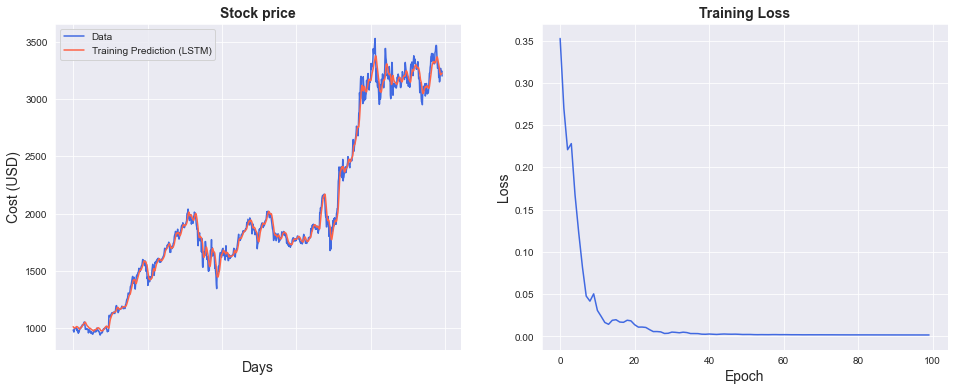

In [21]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [22]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)


Train Score: 58.91 RMSE
Test Score: 125.12 RMSE


In [23]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [25]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [26]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [27]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.2553209066390991
Epoch  1 MSE:  0.21280600130558014
Epoch  2 MSE:  0.14632068574428558
Epoch  3 MSE:  0.09881208837032318
Epoch  4 MSE:  0.026515504345297813
Epoch  5 MSE:  0.019881540909409523
Epoch  6 MSE:  0.05693929269909859
Epoch  7 MSE:  0.024861715734004974
Epoch  8 MSE:  0.0027489070780575275
Epoch  9 MSE:  0.007160878740251064
Epoch  10 MSE:  0.016688888892531395
Epoch  11 MSE:  0.022041257470846176
Epoch  12 MSE:  0.02159261703491211
Epoch  13 MSE:  0.016002977266907692
Epoch  14 MSE:  0.008265656419098377
Epoch  15 MSE:  0.0027236707974225283
Epoch  16 MSE:  0.0021754165645688772
Epoch  17 MSE:  0.005820112302899361
Epoch  18 MSE:  0.009949162602424622
Epoch  19 MSE:  0.01045315433293581
Epoch  20 MSE:  0.007052902597934008
Epoch  21 MSE:  0.0033332218881696463
Epoch  22 MSE:  0.001677958993241191
Epoch  23 MSE:  0.002078048186376691
Epoch  24 MSE:  0.0035961156245321035
Epoch  25 MSE:  0.005028188228607178
Epoch  26 MSE:  0.00544371735304594
Epoch  27 MSE: 

In [29]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

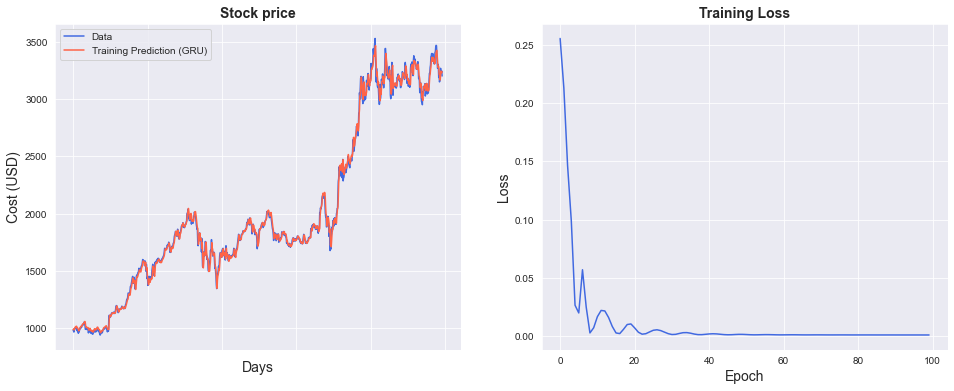

In [30]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [31]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 43.89 RMSE
Test Score: 80.95 RMSE


In [32]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [33]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [164]:
class Time2Vector(nn.Module):
    
    def __init__(self, sequnce_size: int = 1, feature_num: int = 1):
        """
        Apply time to vector embedding.

        Args:
            sequnce_size: size of event sequence in time
            feature_num: number of features in sequence
        """
        super(Time2Vector, self).__init__()
        
        self.sequnce_size = sequnce_size
        self.feature_num = feature_num
        self.weights_linear = torch.nn.Parameter(torch.empty((sequnce_size, feature_num)))
        self.bias_linear = torch.nn.Parameter(torch.empty(feature_num))
        self.weights_periodic = torch.nn.Parameter(torch.empty((sequnce_size, feature_num)))
        self.bias_periodic = torch.nn.Parameter(torch.empty(feature_num))
        self.func_periodic = torch.sin
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """
        Initialize component weights
        """
        # init linear weights
        nn.init.uniform_(self.weights_linear, -1, 1)
        nn.init.uniform_(self.bias_linear, -1, 1)
        
        # init periodic weights
        nn.init.uniform_(self.weights_periodic, -1, 1)
        nn.init.uniform_(self.bias_periodic, -1, 1)

    def forward(self, x):
        weights_linear = self.weights_linear.expand(x.shape[0], self.sequnce_size, self.feature_num)
        linear = torch.mul(weights_linear, x) + self.bias_linear
        weights_periodic = self.weights_periodic.expand(x.shape[0], self.sequnce_size, self.feature_num)
        periodic = self.func_periodic(torch.mul(weights_periodic, x) + self.bias_periodic)
        return torch.cat([linear, periodic], 2)

In [201]:
# input_dim = 1
# hidden_dim = 32
# num_layers = 2
# output_dim = 1
# num_epochs = 100

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(TransformerEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.time_embedding = Time2Vector(19, input_dim)
        # layer = nn.TransformerEncoderLayer(d_model=input_dim+2, nhead=3, batch_first=True, dim_feedforward=hidden_dim)
        layer = nn.TransformerEncoderLayer(d_model=input_dim+2, nhead=3, batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim+2, output_dim)

    def forward(self, input):
        x = self.time_embedding(input)
        x = torch.cat([input, x], 2)
        out = self.transformer(x)
        out = self.fc(out[:, -1, :]) 
        return out

In [202]:
model = TransformerEncoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [203]:
hist = np.zeros(num_epochs)
start_time = time.time()
transformer = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_transformer)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.48115357756614685
Epoch  1 MSE:  0.44828978180885315
Epoch  2 MSE:  0.3784034848213196
Epoch  3 MSE:  0.32877346873283386
Epoch  4 MSE:  0.3058650493621826
Epoch  5 MSE:  0.28875264525413513
Epoch  6 MSE:  0.28637492656707764
Epoch  7 MSE:  0.2840139865875244
Epoch  8 MSE:  0.27951696515083313
Epoch  9 MSE:  0.28188979625701904
Epoch  10 MSE:  0.28105366230010986
Epoch  11 MSE:  0.27838024497032166
Epoch  12 MSE:  0.279524564743042
Epoch  13 MSE:  0.2740689218044281
Epoch  14 MSE:  0.2732904851436615
Epoch  15 MSE:  0.2719764709472656
Epoch  16 MSE:  0.2739647626876831
Epoch  17 MSE:  0.2768368721008301
Epoch  18 MSE:  0.27294307947158813
Epoch  19 MSE:  0.2756166160106659
Epoch  20 MSE:  0.27490234375
Epoch  21 MSE:  0.27434632182121277
Epoch  22 MSE:  0.27691391110420227
Epoch  23 MSE:  0.2765875458717346
Epoch  24 MSE:  0.27316561341285706
Epoch  25 MSE:  0.27306079864501953
Epoch  26 MSE:  0.27486011385917664
Epoch  27 MSE:  0.27390795946121216
Epoch  28 MSE:  0.27

In [204]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_transformer.detach().numpy()))

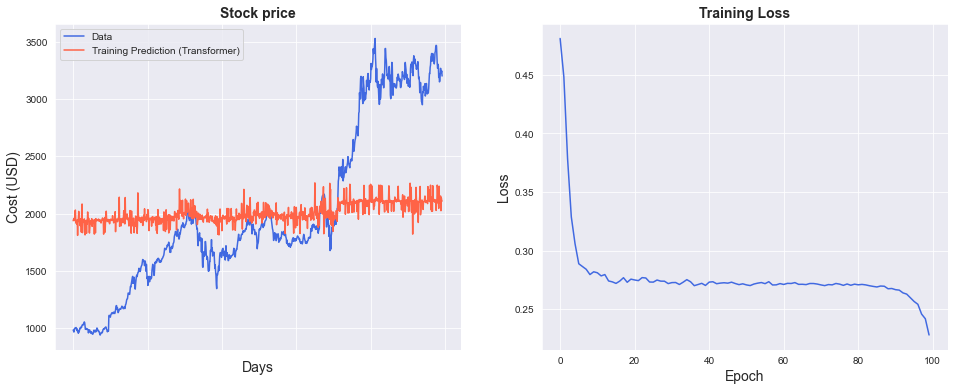

In [205]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (Transformer)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [206]:
class Transformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(Transformer, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.time_embedding = Time2Vector(19, input_dim)
        self.transformer = nn.Transformer(d_model=input_dim+2, nhead=3, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dim_feedforward=hidden_dim, batch_first=True)    
        self.fc = nn.Linear(3, output_dim)

    def forward(self, input, input_y):
        # print(x.shape)
        # print(y.shape)
        x = self.time_embedding(input)
        x = torch.cat([input, x], 2)
        out = self.transformer(x, x)
        # print(f"{out.shape}")
        out = self.fc(out[:, -1, :]) 
        # print(f"{y}")
        # print(f"{out}")
        return out

In [207]:
model = Transformer(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
# optimiser = torch.optim.SGD(model.parameters(),lr=0.1)

In [208]:
hist = np.zeros(num_epochs)
start_time = time.time()
transformer = []

for t in range(num_epochs):
    y_train_pred = model(x_train, y_train_transformer)

    # print(y_train_pred.shape)
    # print(y_train_transformer.shape)
    loss = criterion(y_train_pred, y_train_transformer)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))
print(y_train_pred)

torch.Size([993, 19, 3])
Epoch  0 MSE:  1.274067759513855
torch.Size([993, 19, 3])
Epoch  1 MSE:  0.6145172715187073
torch.Size([993, 19, 3])
Epoch  2 MSE:  0.28901684284210205
torch.Size([993, 19, 3])
Epoch  3 MSE:  0.16642692685127258
torch.Size([993, 19, 3])
Epoch  4 MSE:  0.11809863895177841
torch.Size([993, 19, 3])
Epoch  5 MSE:  0.10242309421300888
torch.Size([993, 19, 3])
Epoch  6 MSE:  0.08949697762727737
torch.Size([993, 19, 3])
Epoch  7 MSE:  0.08022287487983704
torch.Size([993, 19, 3])
Epoch  8 MSE:  0.07493182271718979
torch.Size([993, 19, 3])
Epoch  9 MSE:  0.06922607123851776
torch.Size([993, 19, 3])
Epoch  10 MSE:  0.06381060928106308
torch.Size([993, 19, 3])
Epoch  11 MSE:  0.06368039548397064
torch.Size([993, 19, 3])
Epoch  12 MSE:  0.05678940936923027
torch.Size([993, 19, 3])
Epoch  13 MSE:  0.05912776663899422
torch.Size([993, 19, 3])
Epoch  14 MSE:  0.05756133794784546
torch.Size([993, 19, 3])
Epoch  15 MSE:  0.05794316157698631
torch.Size([993, 19, 3])
Epoch  16 MS

In [209]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_transformer.detach().numpy()))

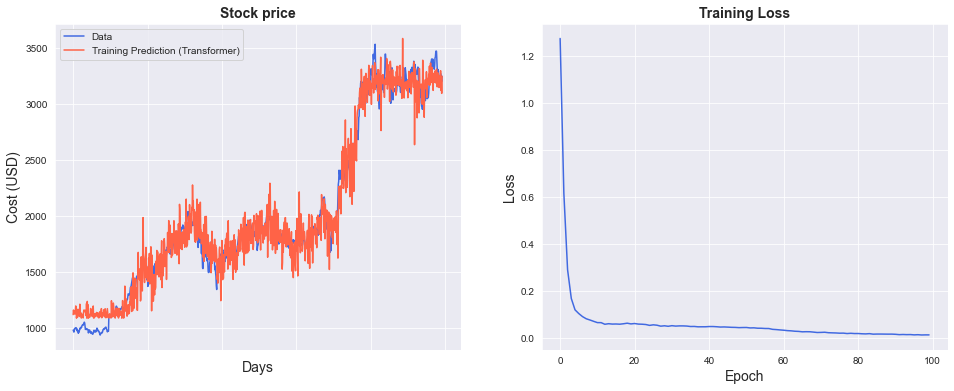

In [210]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (Transformer)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [212]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test, y_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_transformer.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_transformer.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
transformer.append(trainScore)
transformer.append(testScore)
transformer.append(training_time)

torch.Size([248, 19, 3])
Train Score: 149.85 RMSE
Test Score: 300.10 RMSE


In [213]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [215]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (Transformer)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [35]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,58.909804,43.887129
Test RMSE,125.116543,80.946157
Train Time,27.640506,33.904816


In [115]:
## Experiments
transformer_model = nn.Transformer(d_model=5, nhead=5, num_encoder_layers=12, batch_first=True)
src = torch.rand((32, 10, 5))
tgt = torch.rand((32, 1, 5))
out = transformer_model(src, tgt)
print(out.shape)

torch.Size([32, 1, 5])


In [119]:
src = torch.rand((2, 1))
print(src)
print(src.unsqueeze(-1))

tensor([[0.3935],
        [0.4371]])
tensor([[[0.3935]],

        [[0.4371]]])
